In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFECV

# Read Files

In [2]:
rental_model_data = pd.read_csv("../../data/curated/properties_data4.csv")
# if you want to use the newest output rental data to proceed, uncomment the line below and comment the above line.
# rental_model_data = pd.read_csv("../../data/curated/properties_data4_new.csv")
# Remember: using newest rental data will have different result from what we had in presentation and summary notebook!
# Why there's difference? Because the distance computed is different due to data website update

In [3]:
rental_model_data.shape


(2528, 61)

In [4]:
# Drop the unique columns from 'rental_model_data' 
columns = ["property_url", "name", "date_available", "desc", 'nearest_station_index',
            'haversine_distance', 'property_coords','station_coords', 
            'nearest_station_name', 'nearest_hospital_name', 
            'nearest_police_station_name','nearest_fire_station_name',
            'nearest_university_college_name', "nearest_shop_name", 'latitude', 'longitude',
            'region', 'matched_region_x', 'matched_region_y', 'property_index',
            'route_duration_s']


rental_model_data = rental_model_data.drop(columns=columns)
num_columns = rental_model_data.shape[1]
print(f'The number of columns is: {num_columns}')

The number of columns is: 40


In [5]:
nan_counts = rental_model_data.isna().sum()
nan_columns = nan_counts[nan_counts > 0]
nan_columns

Series([], dtype: int64)

# Correlation Analysis for Numerical Features

In [6]:
numerical_internal_features = ['cost_text', 'bed_info', 'bath_info', 'parking',
       'Children enrolled in a preschool or preschool program (no.)',
       'Estimated resident population (no.)', 'Land area (ha)',
       'Median monthly household mortgage payment ($)',
       'Median price of established house transfers ($)',
       'Median total income (excl. Government pensions and allowances) ($)',
       'Median weekly household rental payment ($)', 'Number of jobs',
       'Working age population (aged 15-64 years) (%)', 'avg_crime_count']

numerical_external_features = ['cost_text', 'route_distance_m', 'distance_to_hospital',
       'distance_to_police_station', 'distance_to_fire_station',
       'distance_to_university_college', 'distance_to_melbourne_central',
       'distance_to_the_university_of_melbourne,_parkville_campus',
       'distance_to_la_trobe_university_(bundoora_campus)',
       'distance_to_monash_university,_clayton_campus',
       'distance_to_deakin_university_-_burwood_campus', 'distance_to_shop',
       'kindergarten_count_within_1000m',
       'secondary_primary_school_count_within_3000m',
       'restaurant_bar_count_within_1000m',
       'cinema_theatre_count_within_3000m', 'shop_count_within_1000m',
       'park_count_within_1000m']

### Internal data

In [7]:
internal_features_correlation_matrix = rental_model_data[numerical_internal_features].corr()
internal_pearson_top_10 = internal_features_correlation_matrix['cost_text'].abs().sort_values(ascending=False).head(10)

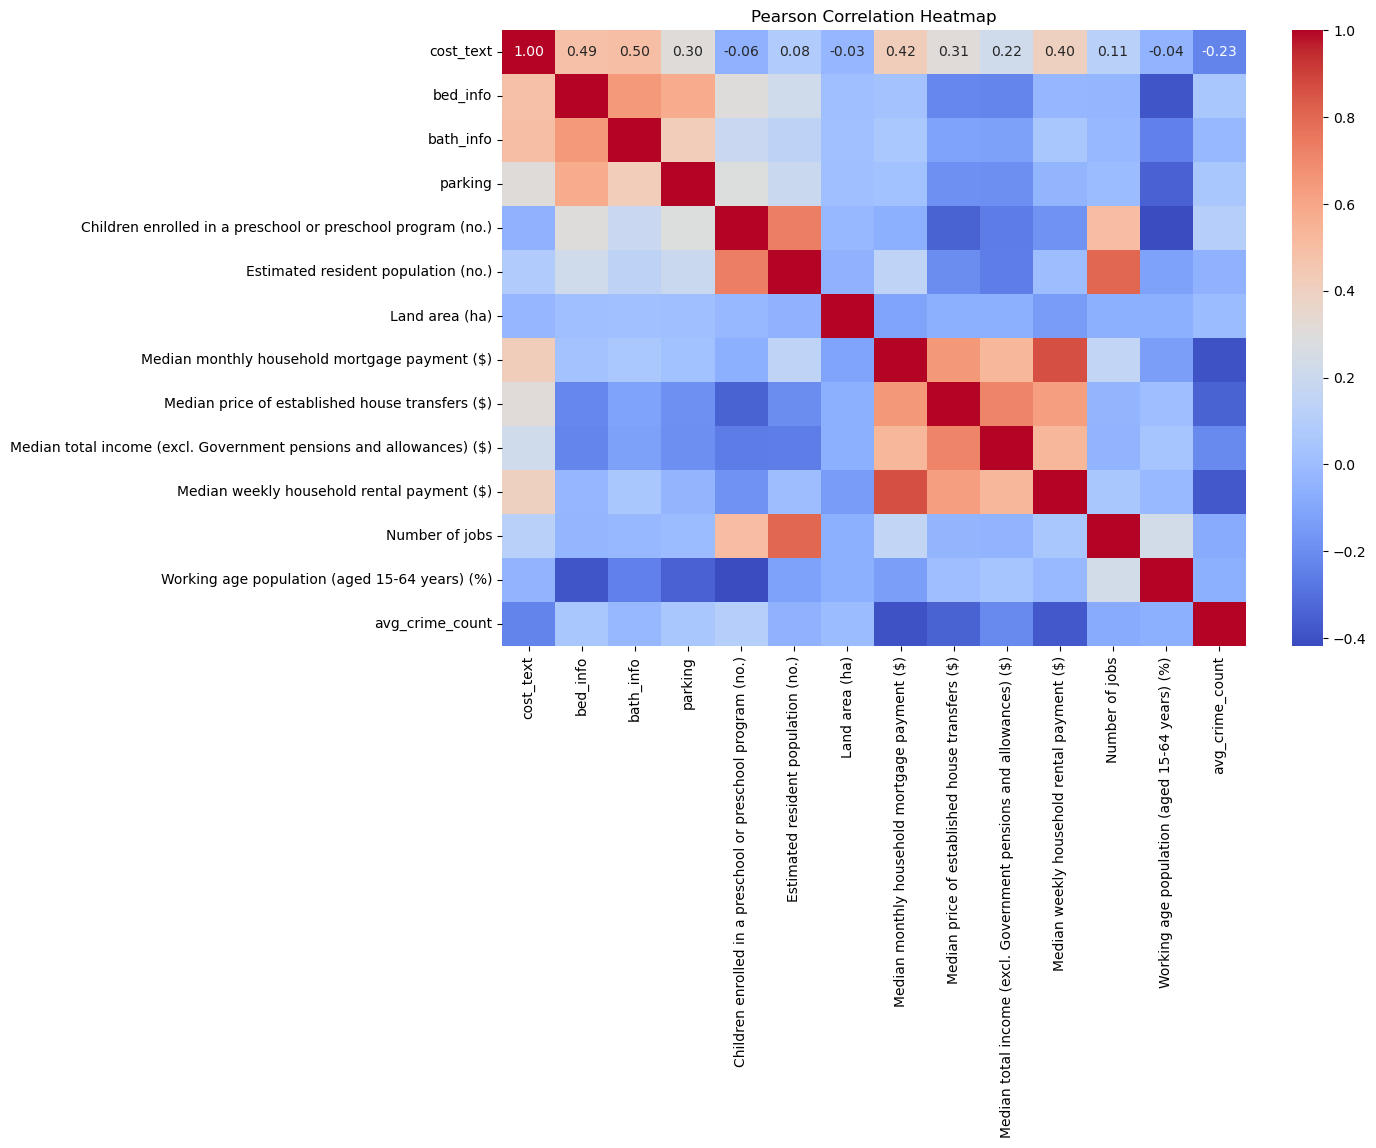

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(internal_features_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson Correlation Heatmap")
plt.show()

In [9]:
internal_spearman_corr_matrix = rental_model_data[numerical_internal_features].corr(method='spearman')
internal_spearman_top_10 = internal_spearman_corr_matrix['cost_text'].abs().sort_values(ascending=False).head(10)

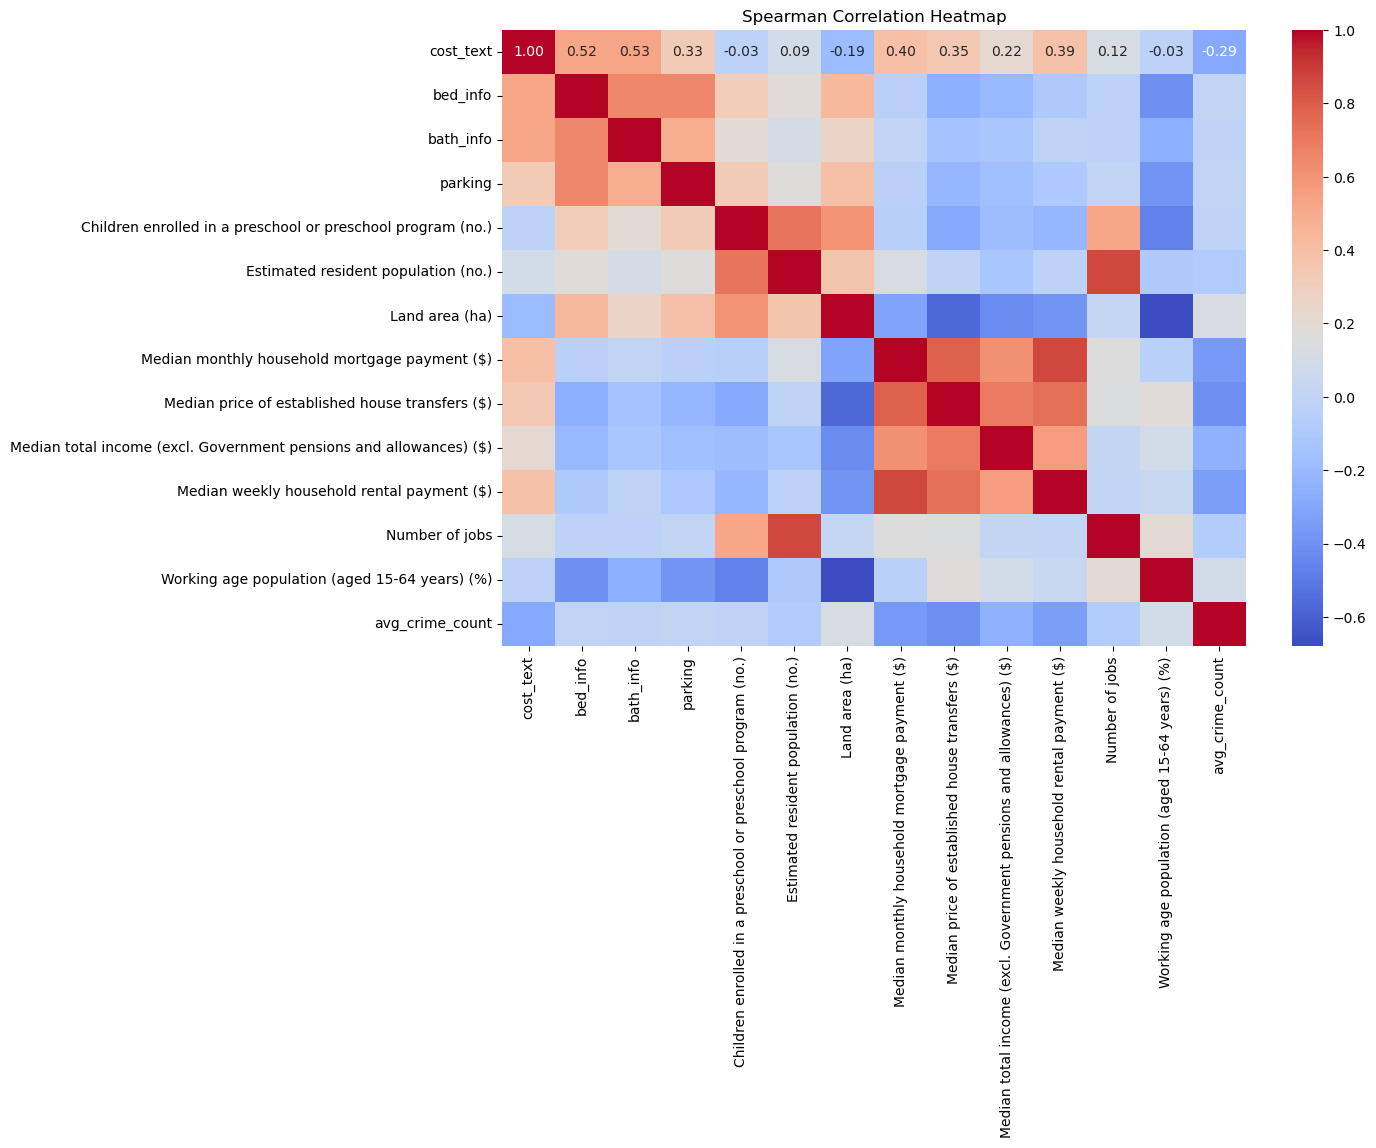

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(internal_spearman_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Spearman Correlation Heatmap")
plt.show()

In [11]:
comparison_df_internal_top_10 = pd.DataFrame({
    'Pearson Feature': internal_pearson_top_10.index,
    'Pearson Value': internal_pearson_top_10.values,
    'Spearman Feature': internal_spearman_top_10.index,
    'Spearman Value': internal_spearman_top_10.values
})

comparison_df_internal_top_10

,Pearson Feature,Pearson Value,Spearman Feature,Spearman Value
0,cost_text,1.000000,cost_text,1.000000
1,bath_info,0.500645,bath_info,0.531006
2,bed_info,0.488654,bed_info,0.523805
3,Median monthly household mortgage payment ($),0.416205,Median monthly household mortgage payment ($),0.397394
4,Median weekly household rental payment ($),0.400285,Median weekly household rental payment ($),0.388225
5,Median price of established house transfers ($),0.312309,Median price of established house transfers ($),0.347622
6,parking,0.302742,parking,0.326018
7,avg_crime_count,0.229785,avg_crime_count,0.292291
8,Median total income (excl. Government pensions...,0.223070,Median total income (excl. Government pensions...,0.215609
9,Number of jobs,0.114885,Land area (ha),0.187709


### external data

In [12]:
external_features_correlation_matrix = rental_model_data[numerical_external_features].corr()
external_pearson_top_10 = external_features_correlation_matrix['cost_text'].abs().sort_values(ascending=False).head(10)

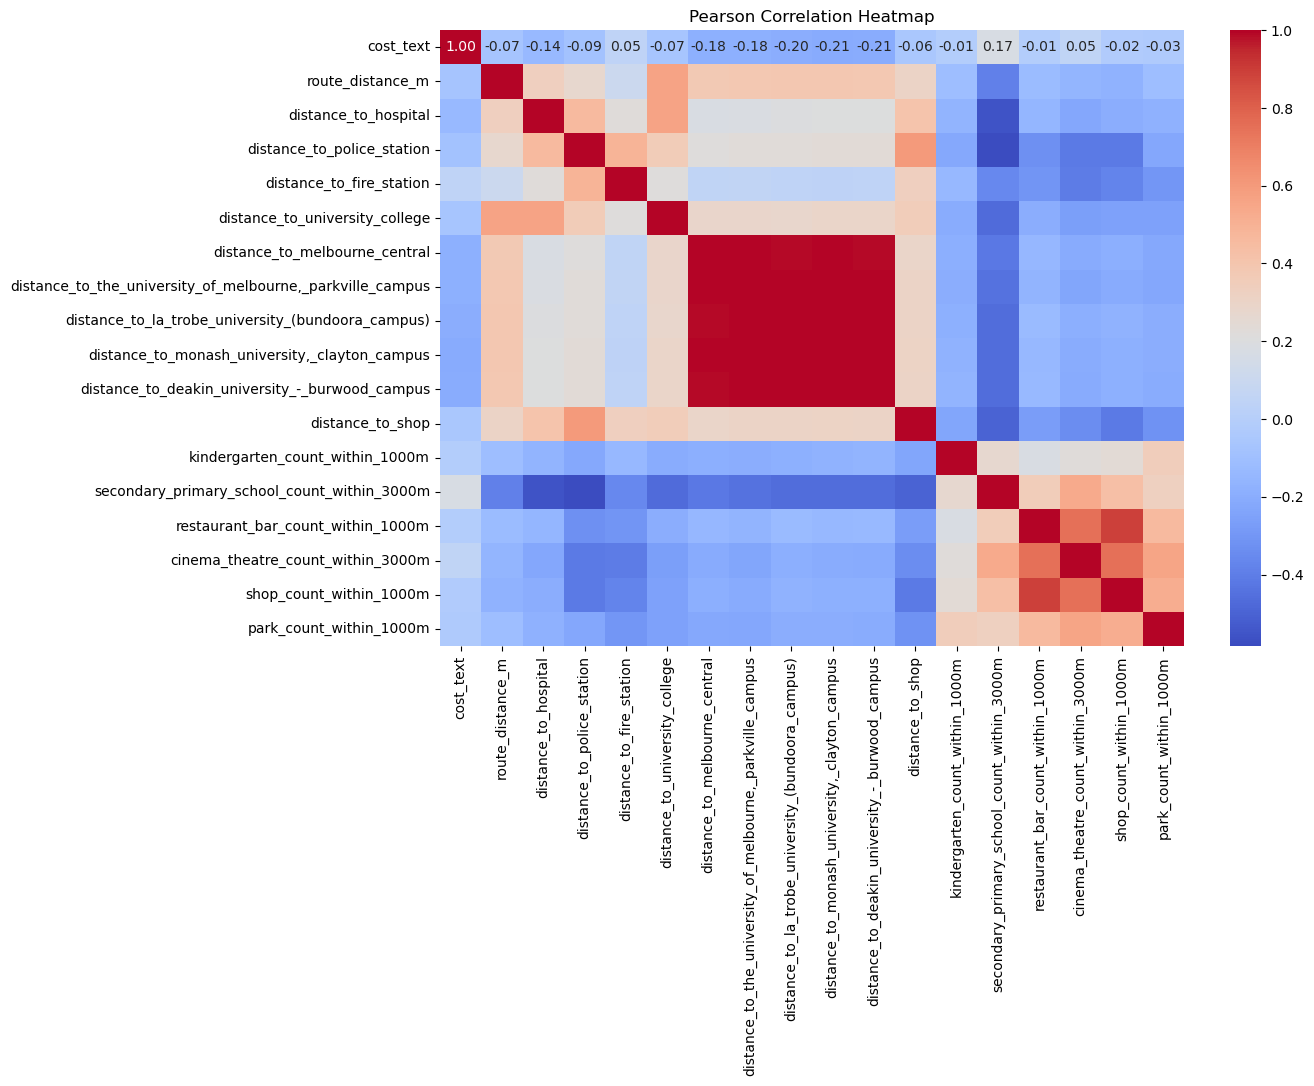

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(external_features_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson Correlation Heatmap")
plt.show()

In [14]:
external_spearman_corr_matrix = rental_model_data[numerical_external_features].corr(method='spearman')
external_spearman_top_10 = external_spearman_corr_matrix['cost_text'].abs().sort_values(ascending=False).head(10)

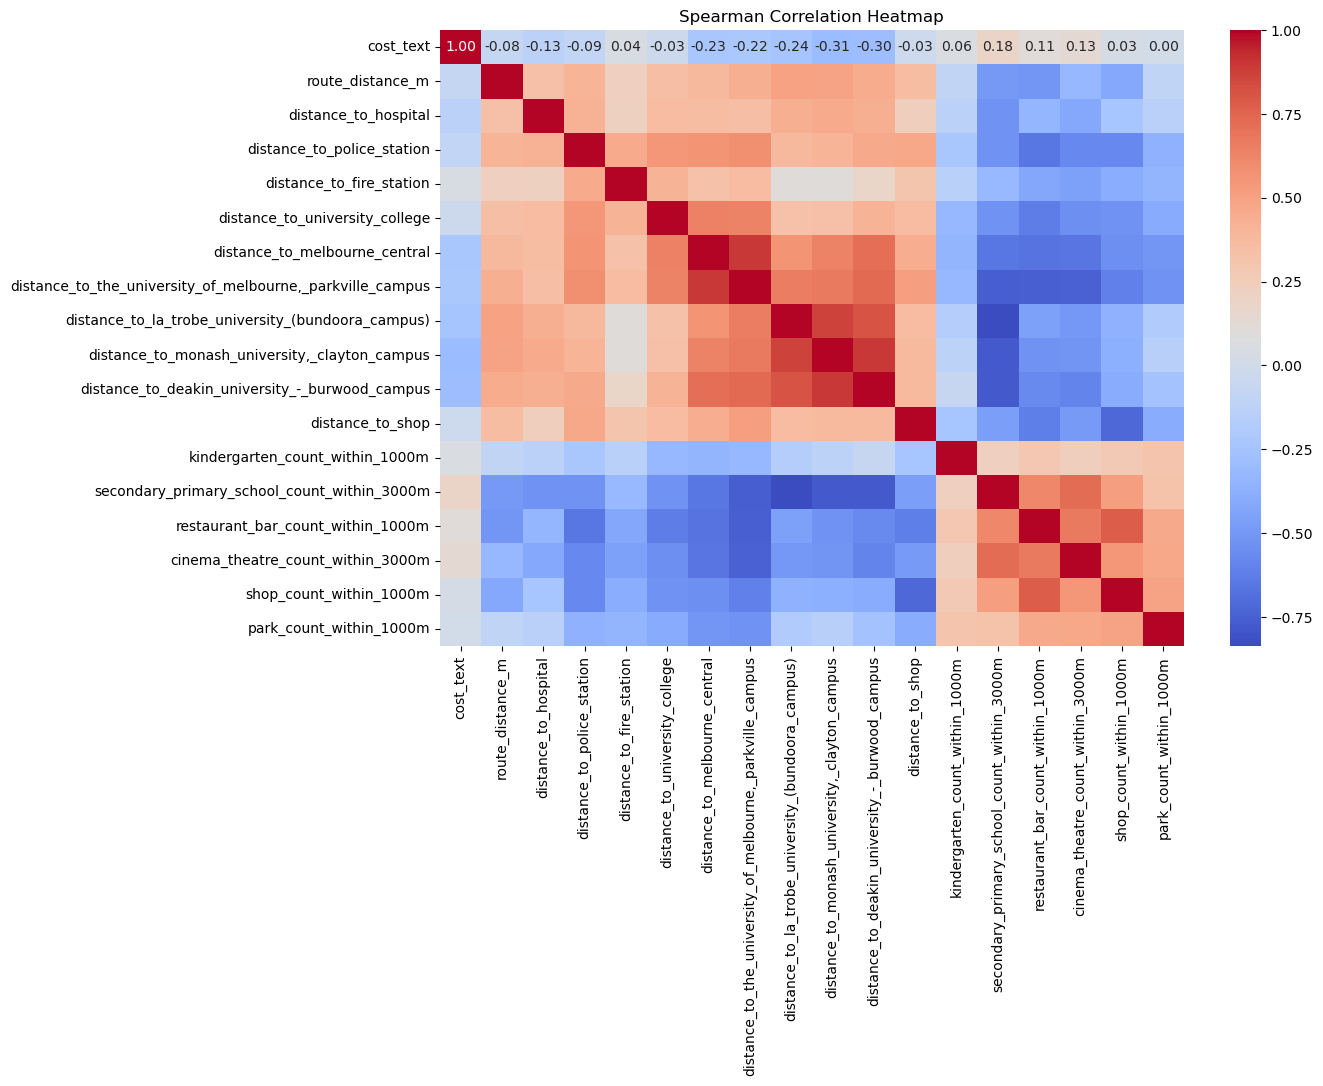

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(external_spearman_corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Spearman Correlation Heatmap")
plt.show()

In [16]:
comparison_df_external_top_10 = pd.DataFrame({
    'Pearson Feature': external_pearson_top_10.index,
    'Pearson Value': external_pearson_top_10.values,
    'Spearman Feature': external_spearman_top_10.index,
    'Spearman Value': external_spearman_top_10.values
})

comparison_df_external_top_10

,Pearson Feature,Pearson Value,Spearman Feature,Spearman Value
0,cost_text,1.000000,cost_text,1.000000
1,"distance_to_monash_university,_clayton_campus",0.209941,"distance_to_monash_university,_clayton_campus",0.305634
2,distance_to_deakin_university_-_burwood_campus,0.206563,distance_to_deakin_university_-_burwood_campus,0.297839
3,distance_to_la_trobe_university_(bundoora_campus),0.198726,distance_to_la_trobe_university_(bundoora_campus),0.243249
4,"distance_to_the_university_of_melbourne,_parkv...",0.184862,distance_to_melbourne_central,0.228368
5,distance_to_melbourne_central,0.183480,"distance_to_the_university_of_melbourne,_parkv...",0.219647
6,secondary_primary_school_count_within_3000m,0.173984,secondary_primary_school_count_within_3000m,0.183388
7,distance_to_hospital,0.138044,cinema_theatre_count_within_3000m,0.133703
8,distance_to_police_station,0.087464,distance_to_hospital,0.129648
9,route_distance_m,0.072208,restaurant_bar_count_within_1000m,0.105581


# Statistical Analysis for Categorical Features

In [17]:
dependent_variable = 'cost_text'
label_encoded_features = ['post_code', 'region_encoded']

In [18]:
property_type_columns = [col for col in rental_model_data if 'property_type_' in col]
one_hot_encoded_features = property_type_columns 
one_hot_encoded_features

['property_type_House',
 'property_type_New Apartments / Off the Plan',
 'property_type_New House & Land',
 'property_type_Studio',
 'property_type_Terrace',
 'property_type_Townhouse',
 'property_type_Villa']

In [19]:
for feature in one_hot_encoded_features:
    groups = [rental_model_data[dependent_variable][rental_model_data[feature] == 1],
              rental_model_data[dependent_variable][rental_model_data[feature] == 0]]
    anova_result = stats.f_oneway(*groups)
    print(f"ANOVA result for {feature}: p-value = {anova_result.pvalue:.2f}")

ANOVA result for property_type_House: p-value = 0.00
ANOVA result for property_type_New Apartments / Off the Plan: p-value = 0.84
ANOVA result for property_type_New House & Land: p-value = 0.81
ANOVA result for property_type_Studio: p-value = 0.00
ANOVA result for property_type_Terrace: p-value = 0.25
ANOVA result for property_type_Townhouse: p-value = 0.04
ANOVA result for property_type_Villa: p-value = 0.95


In [20]:
for feature in label_encoded_features:
    unique_values = rental_model_data[feature].unique()
    groups = [rental_model_data[dependent_variable][rental_model_data[feature] == value] 
              for value in unique_values]
    anova_result = stats.f_oneway(*groups)
    print(f"ANOVA result for {feature}: p-value = {anova_result.pvalue:.2f}")

ANOVA result for post_code: p-value = 0.00
ANOVA result for region_encoded: p-value = 0.00


# Model Analysis 

In [21]:
def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

### Test-Train Split

In [22]:
X = rental_model_data.drop(columns=['cost_text'])
y = rental_model_data['cost_text']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (2022, 39)
Test set size: (506, 39)


In [24]:
all_features = list(X_train.columns)

### Random Forest

In [25]:
# Perform hyperparameter tuning 
rf_reg = RandomForestRegressor(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'max_features': ['log2', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(estimator=rf_reg, param_distributions=rf_param_grid, 
                                      scoring='neg_mean_squared_error', cv=3, 
                                      n_iter=30, verbose=1, random_state=42)
rf_random_search.fit(X_train, y_train)

print("Best parameters found (Random Forest): ", rf_random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found (Random Forest):  {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 7, 'bootstrap': False}


In [26]:
# selects the most important features by iteratively removing the least important ones based on MSE.
rf_best_model = rf_random_search.best_estimator_
rf_rfecv = RFECV(estimator=rf_best_model, step=1, cv=3, scoring='neg_mean_squared_error')
rf_rfecv.fit(X_train, y_train)

rf_selected_features = X_train.columns[rf_rfecv.support_]
print("Selected Features: ", rf_selected_features)
print("Optimal number of features: ", rf_rfecv.n_features_)

Selected Features:  Index(['bed_info', 'bath_info', 'parking',
       'Median monthly household mortgage payment ($)',
       'Median price of established house transfers ($)',
       'Median total income (excl. Government pensions and allowances) ($)',
       'Median weekly household rental payment ($)', 'property_type_House',
       'distance_to_fire_station', 'distance_to_melbourne_central',
       'distance_to_the_university_of_melbourne,_parkville_campus',
       'distance_to_la_trobe_university_(bundoora_campus)',
       'distance_to_monash_university,_clayton_campus',
       'distance_to_deakin_university_-_burwood_campus',
       'secondary_primary_school_count_within_3000m',
       'restaurant_bar_count_within_1000m',
       'cinema_theatre_count_within_3000m'],
      dtype='object')
Optimal number of features:  17


In [27]:
# evaluation metrics
rf_best_model.fit(X_train[rf_selected_features], y_train)
y_pred = rf_best_model.predict(X_test[rf_selected_features])

rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, y_pred)
rf_r2 = r2_score(y_test, y_pred)

n = len(y_test) 
k = X_train.shape[1]  
rf_adj_r2 = adjusted_r2(rf_r2, n, k)

print(f"Mean Squared Error (MSE): {rf_mse}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse}")
print(f"Mean Absolute Error (MAE): {rf_mae}")
print(f"R² Score: {rf_r2}")
print(f"Adjusted R²: {rf_adj_r2}")

Mean Squared Error (MSE): 22069.286410147994
Root Mean Squared Error (RMSE): 148.55735057595768
Mean Absolute Error (MAE): 93.8032259503078
R² Score: 0.7655782169794524
Adjusted R²: 0.7459592265549859


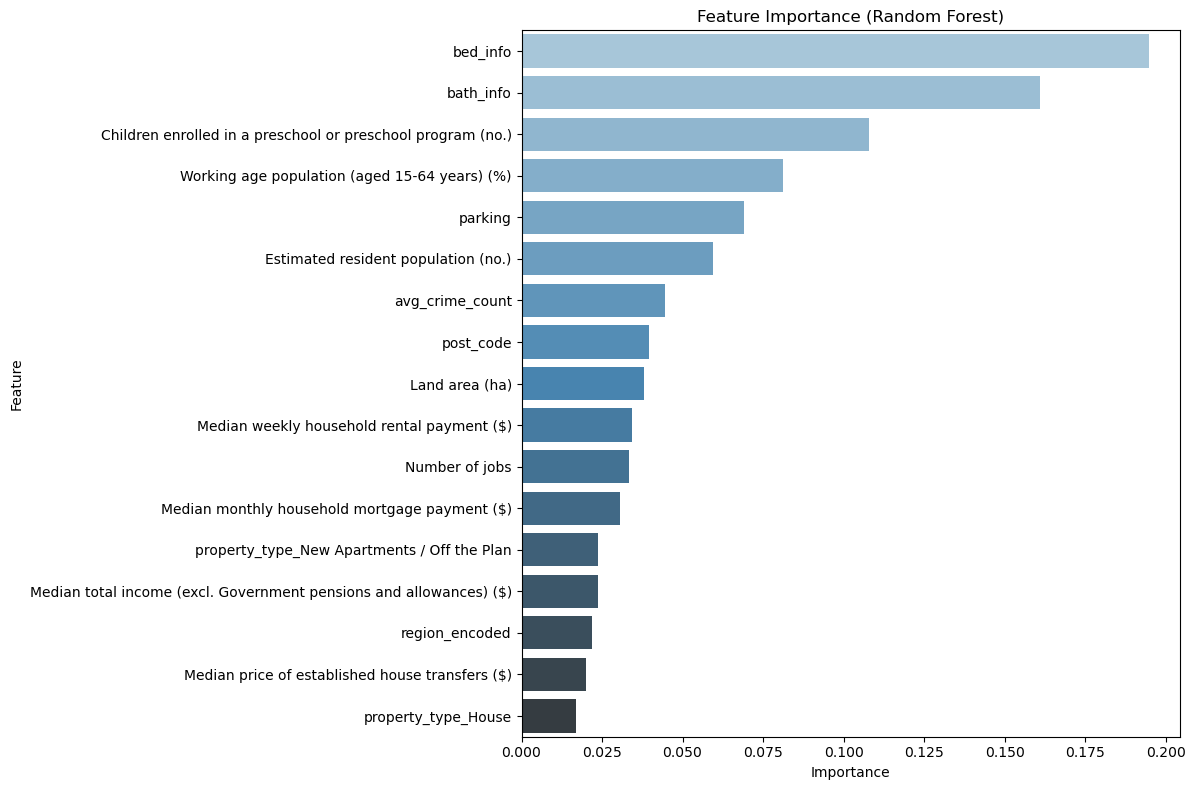

In [28]:
rf_feature_importances = rf_best_model.feature_importances_
feature_names = X_train.columns
rf_indices = np.argsort(rf_feature_importances)[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(x=rf_feature_importances[rf_indices][:20], y=feature_names[rf_indices][:20], palette="Blues_d")
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### XGBoost

In [29]:
# Perform hyperparameter tuning 
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

xg_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

xg_random_search = RandomizedSearchCV(estimator=xg_reg, param_distributions=xg_param_grid, 
                                   scoring='neg_mean_squared_error', cv=3, 
                                   n_iter=30, verbose=1, random_state=42)
xg_random_search.fit(X_train, y_train)
print("Best parameters found: ", xg_random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [30]:
# selects the most important features by iteratively removing the least important ones based on MSE.
xg_best_model = xg_random_search.best_estimator_
xg_rfecv = RFECV(estimator=xg_best_model, step=1, cv=3, scoring='neg_mean_squared_error')
xg_rfecv.fit(X_train, y_train)

xg_selected_features = X_train.columns[xg_rfecv.support_]
print("Selected Features: ", xg_selected_features)
print("Optimal number of features: ", xg_rfecv.n_features_)

Selected Features:  Index(['bed_info', 'bath_info', 'parking', 'Land area (ha)',
       'Median monthly household mortgage payment ($)',
       'Median price of established house transfers ($)',
       'Median total income (excl. Government pensions and allowances) ($)',
       'Median weekly household rental payment ($)',
       'Working age population (aged 15-64 years) (%)', 'region_encoded',
       'property_type_House', 'property_type_Townhouse', 'route_distance_m',
       'distance_to_fire_station',
       'distance_to_the_university_of_melbourne,_parkville_campus',
       'distance_to_monash_university,_clayton_campus',
       'distance_to_deakin_university_-_burwood_campus', 'distance_to_shop',
       'secondary_primary_school_count_within_3000m',
       'cinema_theatre_count_within_3000m'],
      dtype='object')
Optimal number of features:  20


In [31]:
# evaluation metrics
xg_best_model.fit(X_train[xg_selected_features], y_train)
y_pred = xg_best_model.predict(X_test[xg_selected_features])

xg_mse = mean_squared_error(y_test, y_pred)
xg_rmse = np.sqrt(xg_mse)
xg_mae = mean_absolute_error(y_test, y_pred)
xg_r2 = r2_score(y_test, y_pred)

n = len(y_test) 
k = X_train.shape[1]  
xg_adj_r2 = adjusted_r2(xg_r2, n, k)

print(f"Mean Squared Error (MSE): {xg_mse}")
print(f"Root Mean Squared Error (RMSE): {xg_rmse}")
print(f"Mean Absolute Error (MAE): {xg_mae}")
print(f"R² Score: {xg_r2}")
print(f"Adjusted R²: {xg_adj_r2}")

Mean Squared Error (MSE): 17551.723702127594
Root Mean Squared Error (RMSE): 132.4829185296263
Mean Absolute Error (MAE): 91.59857750692858
R² Score: 0.8135641411837944
Adjusted R²: 0.797961140124069


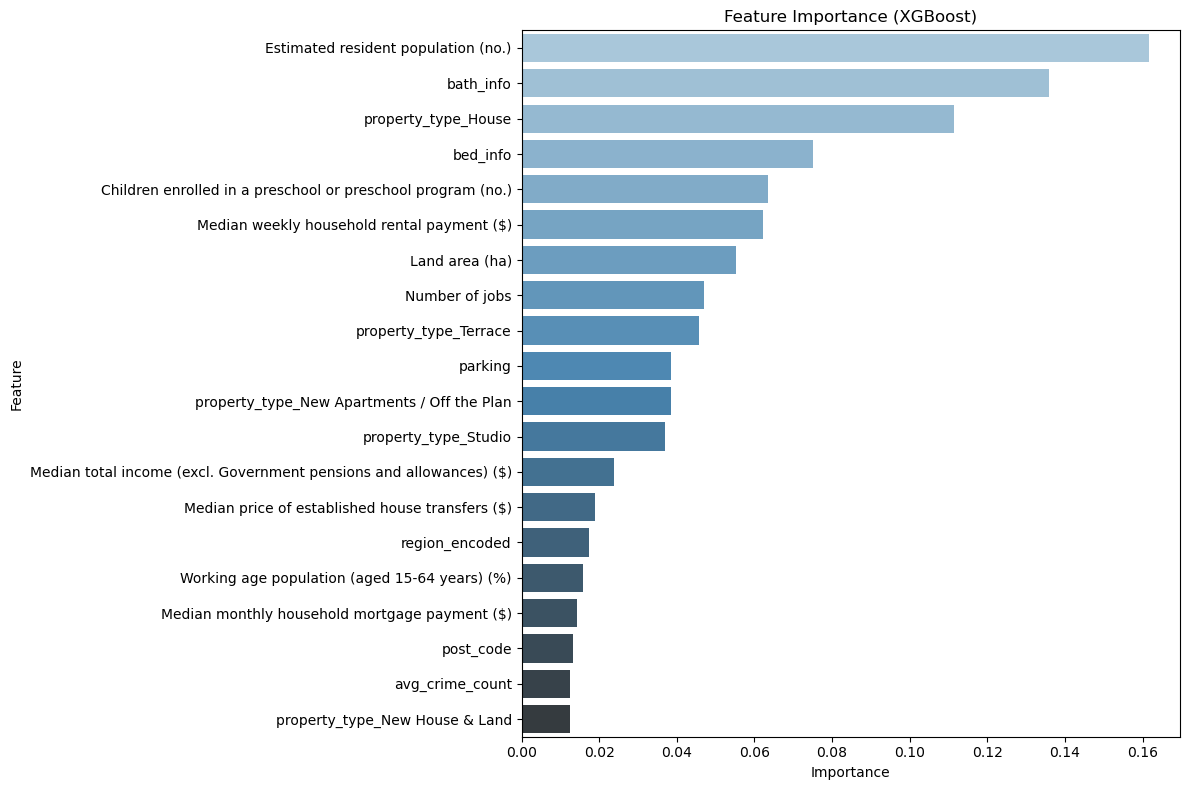

In [32]:
xg_feature_importances = xg_best_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(xg_feature_importances)[::-1]
important_features = sorted(zip(feature_names, xg_feature_importances), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(12, 8))
sns.barplot(x=xg_feature_importances[indices][:20], y=feature_names[indices][:20], palette="Blues_d")
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### GBM

In [33]:
gbm_reg = GradientBoostingRegressor(random_state=42)

gbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbm_random_search = RandomizedSearchCV(estimator=gbm_reg, param_distributions=gbm_param_grid, 
                                       scoring='neg_mean_squared_error', cv=3, 
                                       n_iter=30, verbose=1, random_state=42)

gbm_random_search.fit(X_train, y_train)
print("Best parameters found (GBM): ", gbm_random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found (GBM):  {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 7, 'learning_rate': 0.01}


In [34]:
gbm_best_model = gbm_random_search.best_estimator_
gbm_rfecv = RFECV(estimator=gbm_best_model, step=1, cv=3, scoring='neg_mean_squared_error')
gbm_rfecv.fit(X_train, y_train)

gbm_selected_features = X_train.columns[gbm_rfecv.support_]
print("Selected Features: ", gbm_selected_features)
print("Optimal number of features: ", gbm_rfecv.n_features_)

Selected Features:  Index(['bed_info', 'bath_info', 'parking', 'post_code',
       'Median monthly household mortgage payment ($)',
       'Median price of established house transfers ($)',
       'Median total income (excl. Government pensions and allowances) ($)',
       'Working age population (aged 15-64 years) (%)',
       'property_type_Townhouse', 'route_distance_m', 'distance_to_hospital',
       'distance_to_police_station', 'distance_to_fire_station',
       'distance_to_university_college', 'distance_to_melbourne_central',
       'distance_to_the_university_of_melbourne,_parkville_campus',
       'distance_to_la_trobe_university_(bundoora_campus)',
       'distance_to_monash_university,_clayton_campus',
       'distance_to_deakin_university_-_burwood_campus', 'distance_to_shop',
       'secondary_primary_school_count_within_3000m',
       'restaurant_bar_count_within_1000m',
       'cinema_theatre_count_within_3000m', 'park_count_within_1000m'],
      dtype='object')
Optimal

In [35]:
gbm_best_model.fit(X_train[gbm_selected_features], y_train)
y_pred = gbm_best_model.predict(X_test[gbm_selected_features])

gbm_mse = mean_squared_error(y_test, y_pred)
gbm_rmse = np.sqrt(gbm_mse)
gbm_mae = mean_absolute_error(y_test, y_pred)
gbm_r2 = r2_score(y_test, y_pred)

n = len(y_test) 
k = X_train.shape[1]  
gbm_adj_r2 = adjusted_r2(gbm_r2, n, k)

print(f"Mean Squared Error (MSE): {gbm_mse}")
print(f"Root Mean Squared Error (RMSE): {gbm_rmse}")
print(f"Mean Absolute Error (MAE): {gbm_mae}")
print(f"R² Score: {gbm_r2}")
print(f"Adjusted R²: {gbm_adj_r2}")

Mean Squared Error (MSE): 18038.887264798672
Root Mean Squared Error (RMSE): 134.30892473993927
Mean Absolute Error (MAE): 88.26578154905918
R² Score: 0.8083894495847274
Adjusted R²: 0.7923533734770114


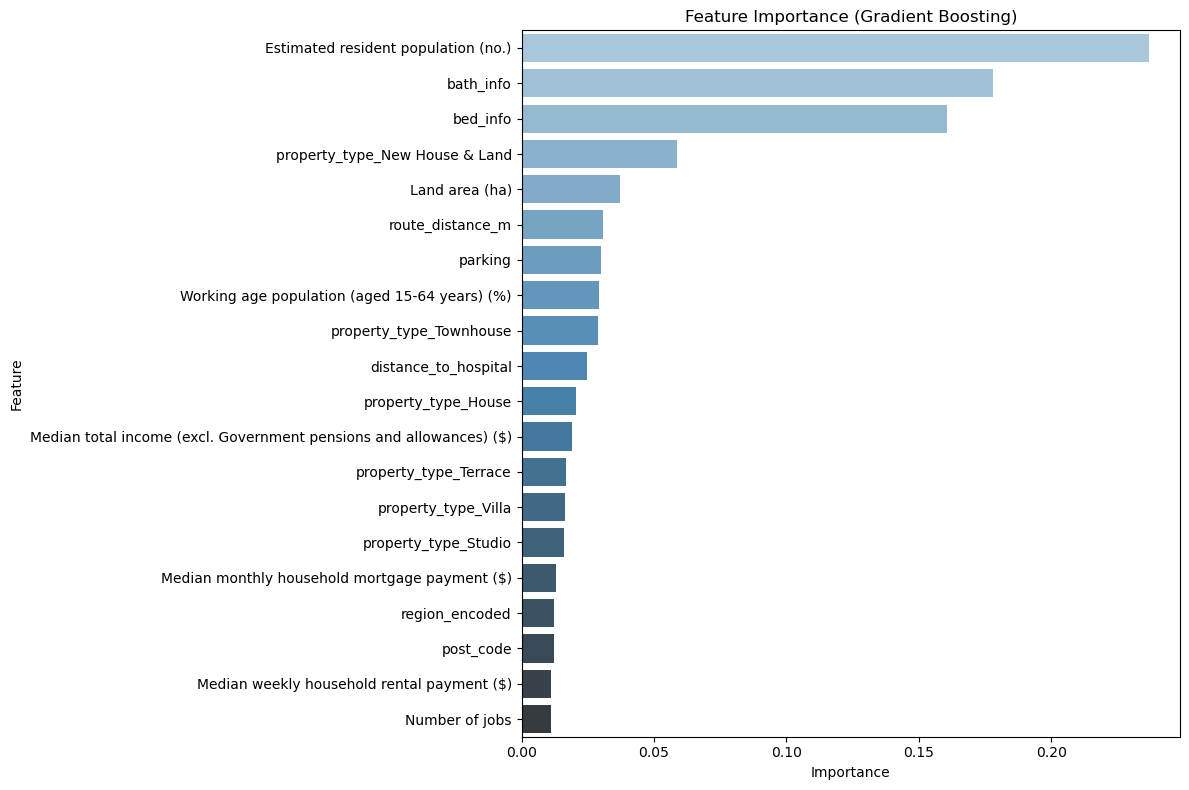

In [36]:
gbm_feature_importances = gbm_best_model.feature_importances_
feature_names = X_train.columns
gbm_indices = np.argsort(gbm_feature_importances)[::-1]
important_features = sorted(zip(feature_names, gbm_feature_importances), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(12, 8))
sns.barplot(x=gbm_feature_importances[gbm_indices][:20], y=feature_names[gbm_indices][:20], palette="Blues_d")
plt.title('Feature Importance (Gradient Boosting)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Save files 

In [37]:
model_metrics_data = {'Model': ["RF", "XGBoost"],
                      'RMSE': [rf_rmse, xg_rmse],
                      'Adjusted R²': [rf_adj_r2, xg_adj_r2]}
model_metrics_df = pd.DataFrame(model_metrics_data)
model_metrics_df

,Model,RMSE,Adjusted R²
0,RF,148.557351,0.745959
1,XGBoost,132.482919,0.797961


In [38]:
feature_selection_data = {'Model': ["Random Forest", "XGBoost"],
                          'Optimal number of features': [rf_rfecv.n_features_, xg_rfecv.n_features_],
                         'Selected features': [list(rf_selected_features), list(xg_selected_features)]}

feature_selection_df = pd.DataFrame(feature_selection_data)


In [39]:
feature_selection_df.to_csv('../../data/curated/feature_selection.csv', index=False)

In [40]:
rf_features = ['bed_info', 'bath_info', 'Estimated resident population (no.)', 'Number of jobs', 'parking', 'Land area (ha)', 'Working age population (aged 15-64 years) (%)', 'Children enrolled in a preschool or preschool program (no.)', 'Median monthly household mortgage payment ($)', 'Median weekly household rental payment ($)']

xgboost_features = ['Land area (ha)', 'distance_to_fire_station', 'bed_info', 'bath_info', 'Median monthly household mortgage payment ($)', 'secondary_primary_school_count_within_3000m', 'kindergarten_count_within_1000m', 'distance_to_monash_university_(clayton_campus)', 'Estimated resident population (no.)', 'distance_to_the_university_of_melbourne_(parkville_campus)']

df_features = pd.DataFrame({
    'Random Forest': rf_features,
    'XGBoost': xgboost_features
})

In [41]:
df_features

,Random Forest,XGBoost
0,bed_info,Land area (ha)
1,bath_info,distance_to_fire_station
2,Estimated resident population (no.),bed_info
3,Number of jobs,bath_info
4,parking,Median monthly household mortgage payment ($)
5,Land area (ha),secondary_primary_school_count_within_3000m
6,Working age population (aged 15-64 years) (%),kindergarten_count_within_1000m
7,Children enrolled in a preschool or preschool ...,distance_to_monash_university_(clayton_campus)
8,Median monthly household mortgage payment ($),Estimated resident population (no.)
9,Median weekly household rental payment ($),distance_to_the_university_of_melbourne_(parkv...
